In [20]:
import pandas as pd
import numpy as np
import re
import string
from fuzzywuzzy import fuzz
from dirty_cat import SimilarityEncoder
from dirty_cat import GapEncoder

## EDA

In [43]:
def preprocess(text):
    '''
    Text preprocessing function for account names. 
    '''
    text=str(text)
    chars = [char for char in text]
    chars.append(' ')

    idx_slices = [0]
    for i in range(len(chars)):
        if i == 0: continue
        #want to keep letters connected with & or / together; cast to lower to avoid slice
        if (chars[i] == '&') or (chars[i] == '/'): chars[i+1] = chars[i+1].lower() 
        #want to keep consecutive letters together
        if chars[i-1] in string.ascii_uppercase: continue

        if chars[i] in string.ascii_uppercase: idx_slices.append(i)

    #slice text at uppercases
    text = " ".join([text[i:j] for i,j in zip(idx_slices, idx_slices[1:]+[None])])
    text = text.lower().strip()
    #text = re.sub('-', ' ', text)
    #text = re.sub('/', ' ', text)
    text = "".join([char for char in text if char not in string.punctuation+string.digits])
    text = re.sub('\\s+', ' ', text).strip()

    return text

In [188]:
acct = "2170 - CIP_Equip, F_F and LHI 4"     #"3563 - Imputed Accrued Interest - 3W"    #'U.S. A/P Laboratory/Testing Science&TechTaxPay'

def preprocess_text(text):

    text = str(text).split(' ')
    words = []

    for word in text:
        #handle text separated by forward slash
        fs_split = word.split('/')
        if len(fs_split) > 1:
            if(list(filter(lambda word: len(word) < 4, fs_split))): word = "".join(fs_split)
            else: word = " ".join(fs_split)

        #handle text with ampersand 
        amp_split = word.split('&')
        if len(amp_split) > 1:
            if(list(filter(lambda word: len(word) < 4, amp_split))): word = "".join(amp_split)
            else: word = " ".join(amp_split)

        #handle text with period abbreviations
        per_split = word.split('.')
        if len(per_split) > 1:
            if(list(filter(lambda word: len(word) < 4, per_split))): word = "".join(per_split)
            else: word = " ".join(per_split)

        #handle text with alpha char and digit combined
        digits = [char for char in word if char in string.digits]
        if(len(digits) > 0):
            check_non_digits = [char for char in word if char not in string.digits]
            if(len(check_non_digits) > 0): continue

        #handle text separated by underscore
        undrscr_split = word.split('_')
        if len(undrscr_split) > 1:
            if(list(filter(lambda word: len(word) < 3, undrscr_split))): word = "".join(undrscr_split)
            else: word = " ".join(undrscr_split)
        
        #handle single strings with words separated by capitals
        chars = [char for char in word]

        idx_slices = [0]
        for i in range(len(chars)):
            if i == 0: continue
            #want to keep consecutive letters together
            if chars[i-1] in string.ascii_uppercase: continue
            if chars[i] in string.ascii_uppercase: idx_slices.append(i)

        word = " ".join([word[i:j] for i,j in zip(idx_slices, idx_slices[1:]+[None])])
        words.append(word)
    
    text = " ".join(words).lower().strip()
    text = re.sub('-', ' ', text)
    text = re.sub('–', ' ', text)
    text = "".join([char for char in text if char not in string.punctuation+string.digits])
    text = re.sub('\\s+', ' ', text).strip()

    return text

preprocess_text(acct)

'cip equip ff and lhi'

In [165]:
path = 'C:/Users/devquinn/OneDrive - Deloitte (O365D)/Desktop/atom-dc-coa/dc-atom-coa/project/data/'

### System

In [189]:
file = 'SAP.csv'
df_sap = pd.read_csv(path+file)
df_sap.head(2)

,System,Division,Industry,Source Account #,Source Account Description,Target Account #,Target Account Description,Source Level 1,Source Level 2,Source Level 3,...,Source Level 5,Source Level 6,Source Level 7,Source Level 8,Source Level 9,Source Level 10,Target Level 1,Target Level 2,Target Level 3,Target Level 4
0,SAP,Manufacturing,Drugs,102861,DIVISION CONTROL,29030000.0,Paid in Capital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SAP,Manufacturing,Drugs,101770,ACCUM DEP-SOFTWARE,16001400.0,PPE - Accum. Depr. - Computer Software,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
sap_src = df_sap['Source Account Description'].apply(preprocess_text).tolist()
sap_tar = df_sap['Target Account Description'].apply(preprocess_text).tolist()

In [192]:
file = 'Oracle.csv'
df_oracle = pd.read_csv(path+file)

oracle_src = df_oracle['Source Account Description'].apply(preprocess_text).tolist()
oracle_tar = df_oracle['Target Account Description'].apply(preprocess_text).tolist()

oracle_tar

['lt ar ic twx intraco',
 'inventory reserves finished goods',
 'acquired programming costs less amort',
 'ap tax sales use st loc',
 'cash',
 'ar employees other',
 'apic fas restricted stock',
 'dr subscriptions',
 'nc non trade receivables nc other non trade receivables',
 'ap payroll tax suta tax employer',
 'ap payroll tax loc inc tax withheld',
 'ap tax sales use st loc',
 'nc accrd particip and residuals',
 'intangible assets software acquisition',
 'land exchange',
 'nc acquired programming costs less amort',
 'current asset other',
 'cash',
 'current asset other',
 'cash',
 'ar other general',
 'ap tax sales use st loc',
 'equity investment acquisition',
 'lt ar ic twx intraco',
 'lt note rec ic regular',
 'lt ar ic twx intraco',
 'current def chgs assets other',
 'ar other general',
 'ap tax sales use st loc',
 'ap tax sales use st loc',
 'ap tax sales use st loc',
 'obligations under capital leases',
 'accrued interest othr',
 'ap tax sales use st loc',
 'inventory finished 

In [193]:
df_oracle['Target Account Description'].tolist()

['LT A/R IC - TWX - Intraco',
 'Inventory Reserves-Finished Goods',
 'Acquired programming costs, less amort.',
 'A/P-Tax-Sales & Use-St/Loc',
 'CASH',
 'A/R-Employees-Other',
 'APIC-FAS 123 Restricted Stock',
 'D/R Subscriptions',
 'N/C Non-trade Receivables - N/C Other Non-Trade Receivables',
 'A/P-Payroll-Tax-SUTA Tax-Employer',
 'A/P-Payroll-Tax-Loc Inc Tax Withheld',
 'A/P-Tax-Sales & Use-St/Loc',
 'N/C Accr`d particip. and residuals',
 'Intangible Assets-Software - Acquisition',
 'Land - Exchange',
 'N/C Acquired Programming Costs, less amort.',
 'Current Asset-Other',
 'CASH',
 'Current Asset-Other',
 'CASH',
 'A/R-Other-General',
 'A/P-Tax-Sales & Use-St/Loc',
 'Equity Investment-Acquisition',
 'LT A/R IC - TWX - Intraco',
 'LT Note Rec-IC-Regular',
 'LT A/R IC - TWX - Intraco',
 'Current Def Chgs & Assets Other',
 'A/R-Other-General',
 'A/P-Tax-Sales & Use-St/Loc',
 'A/P-Tax-Sales & Use-St/Loc',
 'A/P-Tax-Sales & Use-St/Loc',
 'Obligations Under Capital Leases',
 'Accrued Inte

In [171]:
df_oracle.iloc[459, :]

System                                                Oracle
Division                                     Wholesale Trade
Industry                      Groceries and Related Products
Source Account #                                      622035
Source Account Description                               NaN
Target Account #                                      660003
Target Account Description       Warehouse/Delivery Supplies
Name: 459, dtype: object

In [ ]:
file = 'MSDynamics.csv'
df_msd = pd.read_csv(path+file)

## Predictions

In [2]:
path = 'C:/Users/devquinn/OneDrive - Deloitte (O365D)/Desktop/atom-dc-coa/dc-atom-coa/project/predictions/'

In [3]:
file = 'SAP_predictions.csv'
df_sap = pd.read_csv(path+file)
df_sap.head(3)

,Legacy Account,Generated New Account,Confidence Score,Targets,Bleu Score
0,cor citibank multi corp,cash,97.310463,cash,1.0000
1,cip mach equip,cip me bld man,68.342517,ppe construction in process cip,0.1947
2,cor northern trust,cash,93.215906,cash,1.0000


In [4]:
def calc_sim(cols):
    return fuzz.token_sort_ratio(cols[0], cols[1])/100

df_sap[['Generated New Account', 'Targets']].apply(calc_sim, axis=1)

0        1.00
1        0.31
2        1.00
3        0.59
4        0.48
         ... 
19190    0.59
19191    0.77
19192    0.70
19193    0.52
19194    0.52
Length: 19195, dtype: float64

In [5]:
def calc_sim(cols):
    return fuzz.token_sort_ratio(cols[0], cols[1])/100

def calc_metrics(df):

    avg_conf = np.mean(df['Confidence Score'])
    avg_bleu = np.mean(df['Bleu Score'])
    avg_sim = np.mean(df[['Generated New Account', 'Targets']].apply(calc_sim, axis=1))

    return avg_bleu, avg_sim, avg_conf

calc_metrics(df_sap)


(0.40404844699140763, 0.5849518103672844, 57.82486716284506)

In [6]:
metrics = {}
metrics['SAP'] = calc_metrics(df_sap)

In [7]:
file = 'Oracle_predictions.csv'
df_oracle = pd.read_csv(path+file)
metrics['Oracle'] = calc_metrics(df_oracle)

In [8]:
file = 'MSDynamics_predictions.csv'
df_msd = pd.read_csv(path+file)
metrics['MS Dynamics'] = calc_metrics(df_msd)

In [9]:
file = 'Consumer-CP_predictions.csv'
df_cp = pd.read_csv(path+file)
metrics['Consumer-CP'] = calc_metrics(df_cp)

In [10]:
file = 'LSHC_predictions.csv'
df_lshc = pd.read_csv(path+file)
metrics['LSHC'] = calc_metrics(df_lshc)

In [11]:
file = 'TMT_predictions.csv'
df_tmt = pd.read_csv(path+file)
metrics['TMT'] = calc_metrics(df_tmt)

In [12]:
metrics

{'SAP': (0.40404844699140763, 0.5849518103672844, 57.82486716284506),
 'Oracle': (0.29729914583333383, 0.4996770833333334, 50.93838792493707),
 'MS Dynamics': (0.23707946181818157, 0.4593381818181811, 44.97278484660682),
 'Consumer-CP': (0.3622275949979803, 0.5564171036708297, 55.65533947517879),
 'LSHC': (0.4200222039507714, 0.5928720653635353, 57.727314838604265),
 'TMT': (0.2529090140845067, 0.4483333333333334, 49.47787336529992)}

In [13]:
systems = list(metrics.keys())[:3]
industries = list(metrics.keys())[3:]

system_metrics = list(metrics.values())[:3]
industry_metrics = list(metrics.values())[3:]

In [14]:
df_system_metrics = pd.DataFrame()
df_system_metrics.insert(0, ' ', ['Bleu Score', 'Similarity', 'Confidence'])
for i in range(len(systems)):
    system = systems[i]
    metrics = system_metrics[i]
    df_system_metrics[system] = metrics

df_system_metrics

,,SAP,Oracle,MS Dynamics
0,Bleu Score,0.404048,0.297299,0.237079
1,Similarity,0.584952,0.499677,0.459338
2,Confidence,57.824867,50.938388,44.972785


In [15]:
df_industry_metrics = pd.DataFrame()
df_industry_metrics.insert(0, ' ', ['Bleu Score', 'Similarity', 'Confidence'])
for i in range(len(industries)):
    industry = industries[i]
    metrics = industry_metrics[i]
    df_industry_metrics[industry] = metrics

df_industry_metrics

,,Consumer-CP,LSHC,TMT
0,Bleu Score,0.362228,0.420022,0.252909
1,Similarity,0.556417,0.592872,0.448333
2,Confidence,55.655339,57.727315,49.477873


In [16]:
systems

['SAP', 'Oracle', 'MS Dynamics']

In [17]:
sap_avg_src2tar_sim = np.mean(df_sap[['Legacy Account', 'Targets']].apply(calc_sim, axis=1))
oracle_avg_src2tar_sim = np.mean(df_oracle[['Legacy Account', 'Targets']].apply(calc_sim, axis=1))
msd_avg_src2tar_sim = np.mean(df_msd[['Legacy Account', 'Targets']].apply(calc_sim, axis=1))
system_src2tar_sims = [sap_avg_src2tar_sim, oracle_avg_src2tar_sim, msd_avg_src2tar_sim]
system_src2tar_sims

[0.5807340453243081, 0.6806406250000003, 0.5143854545454541]

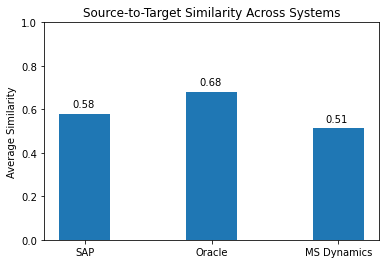

In [18]:
import matplotlib.pyplot as plt

plt.bar(systems, system_src2tar_sims, width=0.4)
plt.title('Source-to-Target Similarity Across Systems')
plt.ylabel('Average Similarity')

xlocs, xlabs = plt.xticks()
xlocs=[i for i in range(0,3)]
plt.ylim([0, 1])


for i, v in enumerate(system_src2tar_sims):
    v = round(v, 2)
    plt.text(xlocs[i] - 0.1, v + 0.03, str(v))

In [19]:
industries

['Consumer-CP', 'LSHC', 'TMT']

In [20]:
cp_avg_src2tar_sim = np.mean(df_cp[['Legacy Account', 'Targets']].apply(calc_sim, axis=1))
lshc_avg_src2tar_sim = np.mean(df_lshc[['Legacy Account', 'Targets']].apply(calc_sim, axis=1))
tmt_avg_src2tar_sim = np.mean(df_tmt[['Legacy Account', 'Targets']].apply(calc_sim, axis=1))
ind_src2tar_sims = [cp_avg_src2tar_sim, lshc_avg_src2tar_sim, tmt_avg_src2tar_sim]
ind_src2tar_sims

[0.6934885034287973, 0.45105698624469676, 0.4794366197183098]

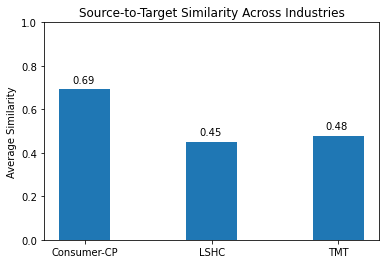

In [21]:
plt.bar(industries, ind_src2tar_sims, width=0.4)
plt.title('Source-to-Target Similarity Across Industries')
plt.ylabel('Average Similarity')

xlocs, xlabs = plt.xticks()
xlocs=[i for i in range(0,3)]
plt.ylim([0, 1])


for i, v in enumerate(ind_src2tar_sims):
    v = round(v, 2)
    plt.text(xlocs[i] - 0.1, v + 0.03, str(v))

In [25]:
system_num_accounts = [len(df_sap), len(df_oracle), len(df_msd)]
ind_num_accounts = [len(df_cp), len(df_lshc), len(df_tmt)]

print(system_num_accounts, ind_num_accounts)

[19195, 1920, 1375] [12395, 9669, 426]


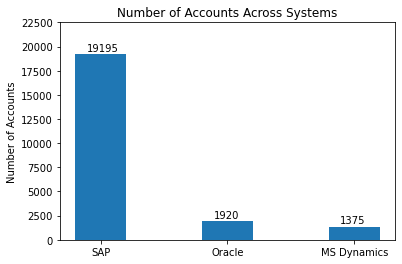

In [49]:
plt.bar(systems, system_num_accounts, width=0.4)
plt.title('Number of Accounts Across Systems')
plt.ylabel('Number of Accounts')

xlocs, xlabs = plt.xticks()
xlocs=[i for i in range(0,3)]
plt.ylim([0, 22500])

for i, v in enumerate(system_num_accounts):
    plt.text(xlocs[i] -0.11, v + 350, str(v))

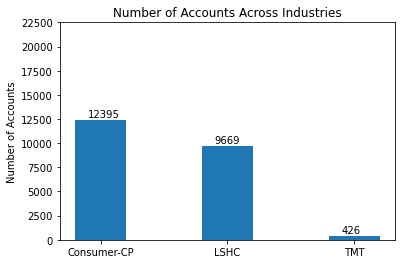

In [62]:
plt.bar(industries, ind_num_accounts, width=0.4)
plt.title('Number of Accounts Across Industries')
plt.ylabel('Number of Accounts')

xlocs, xlabs = plt.xticks()
xlocs=[i for i in range(0,3)]
plt.ylim([0, 22500])

for i, v in enumerate(ind_num_accounts):
    plt.text(xlocs[i] -0.1, v + 300, str(v))